In [1]:
from pyarrow import parquet as pq 
import numpy as np
import pandas as pd

In [2]:
unique_seqs_small = set()
unique_seqs_large = set()
path_to_large = '/cmnfs/data/proteomics/Prosit_PTMs/TUM_mod_acetylated.parquet'
path_to_small = '/cmnfs/data/proteomics/Prosit_PTMs/21PTMs/Kmod_Acetyl.parquet'
total_seqs_small = 0
total_seqs_large = 0
for batch in pq.ParquetFile(path_to_small).iter_batches():
    for seq in batch['modified_sequence']:
        total_seqs_small += 1
        unique_seqs_small.add(seq)
for batch in pq.ParquetFile(path_to_large).iter_batches():
    for seq in batch['modified_sequence']:
        total_seqs_large += 1
        unique_seqs_large.add(seq)

In [3]:
total_seqs_small, total_seqs_large

(8549, 1037199)

In [4]:
len(unique_seqs_small), len(unique_seqs_large)

(300, 36387)

In [7]:
len(unique_seqs_small & unique_seqs_large)

0

In [12]:
# create a test set for small containing 10.000 seqs from the large set and a test set for large containing all seqs from the small set
batch_frames = list()
for batch in pq.ParquetFile(path_to_large).iter_batches():
    batch_frames.append(batch.to_pandas().reset_index())

In [10]:
len(batch_frames)

16

In [15]:
all_batches = pd.concat(batch_frames, axis=0)

In [17]:
rand_idx = np.random.randint(0, len(all_batches), size=10_000)

In [20]:
test_set_for_small = all_batches.iloc[rand_idx, :]

In [21]:
test_set_for_small.to_parquet('/cmnfs/proj/bmpc_dlomix/datasets/parquet/Kmod_Acetylated_test_for_small.parquet')

### Make predictions on test set

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from dlomix.interface import load_keras_model, process_dataset
from dlomix.losses import masked_spectral_distance
from tensorflow.keras.models import load_model

2024-08-13 10:29:55.787048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 10:29:55.787088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 10:29:55.788747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 10:29:55.797890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 10:29:57.949642: W tensorflow/compiler/tf2


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [41]:
small_model = load_model('/cmnfs/proj/bmpc_dlomix/models/refinement_transfer_learning/single_ptm_models/refined_to_Kmod_Acetyl.keras', compile=False)
large_model = load_model('/cmnfs/proj/bmpc_dlomix/models/refinement_transfer_learning/single_ptm_models/refined_to_TUM_mod_acetylated.keras', compile=False)

In [42]:
small_model.alphabet = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '[]-': 21, '-[]': 22, '[UNIMOD:737]-': 21, 'M[UNIMOD:35]': 23, 'K[UNIMOD:737]': 24, 'C[UNIMOD:4]': 25, '[UNIMOD:1]-': 26, 'K[UNIMOD:1]': 28}
large_model.alphabet = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '[]-': 21, '-[]': 22, '[UNIMOD:737]-': 21, 'M[UNIMOD:35]': 23, 'K[UNIMOD:737]': 24, 'C[UNIMOD:4]': 25, '[UNIMOD:1]-': 26, 'K[UNIMOD:1]': 28}

In [43]:
testset_small = process_dataset(
    parquet_file_path='/cmnfs/proj/bmpc_dlomix/datasets/parquet/Kmod_Acetylated_test_for_small.parquet',
    model=small_model,
    val_ratio=0.000001
)

Casting the dataset: 100%|██████████| 1/1 [00:00<00:00, 39.79 examples/s]


In [64]:
testset_large = process_dataset(
    parquet_file_path='/cmnfs/data/proteomics/Prosit_PTMs/21PTMs/Kmod_Acetyl.parquet',
    model=small_model,
    val_ratio=0.000001
)

Casting the dataset: 100%|██████████| 1/1 [00:00<00:00, 35.73 examples/s]


In [46]:
sd_small = list()
for batch, y_true in testset_small.tensor_train_data:
    # print('Max value: ', batch['modified_sequence'].numpy().max())
    # print('Min value: ', batch['modified_sequence'].numpy().min())
    y_pred = small_model.predict(batch)
    sd_small.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

25/25 [==============================] - 4s 77ms/step


In [47]:
sd_large = list()
for batch, y_true in testset_large.tensor_train_data:
    # print('Max value: ', batch['modified_sequence'].numpy().max())
    # print('Min value: ', batch['modified_sequence'].numpy().min())
    y_pred = large_model.predict(batch)
    sd_large.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

12/12 [==============================] - 3s 78ms/step


Text(0.5, 0, 'Spectral Angle')

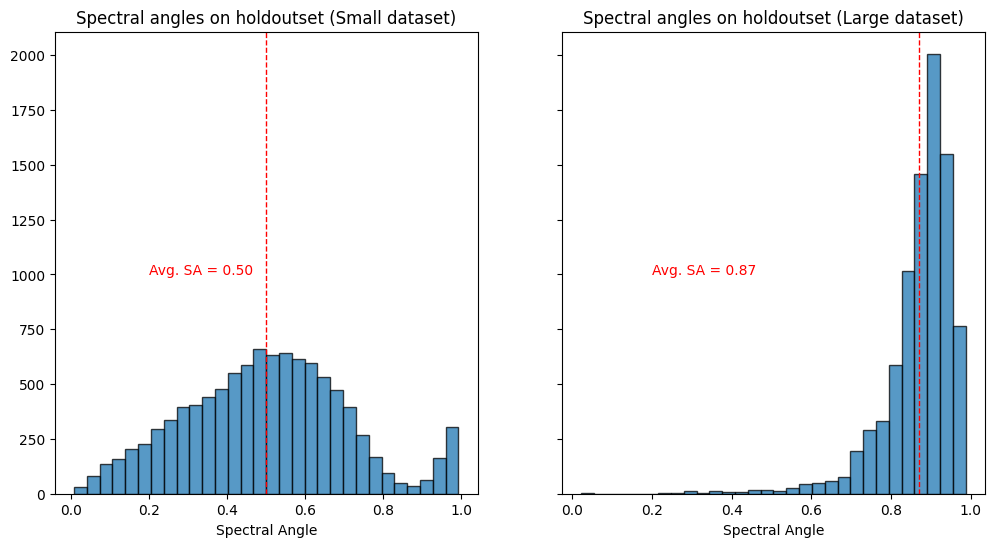

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sa_small = [1 - sd for sd in sd_small]
avg_sa_scratch = np.mean(sa_small)
ax[0].hist(sa_small, bins=30, alpha=0.75, edgecolor='black')
ax[0].axvline(avg_sa_scratch, color='r', linestyle='dashed', linewidth=1)
ax[0].text(0.2, 1e3, f'Avg. SA = {avg_sa_scratch:.2f}', color='r')
ax[0].set_title(f'Spectral angles on holdoutset (Small dataset)')
ax[0].set_xlabel('Spectral Angle')

sa_large = [1 - sd for sd in sd_large]
avg_sa_refined = np.mean(sa_large)
ax[1].hist(sa_large, bins=30, alpha=0.75, edgecolor='black')
ax[1].axvline(avg_sa_refined, color='r', linestyle='dashed', linewidth=1)
ax[1].text(0.2, 1e3, f'Avg. SA = {avg_sa_refined:.2f}', color='r')
ax[1].set_title(f'Spectral angles on holdoutset (Large dataset)')
ax[1].set_xlabel('Spectral Angle')

### Check if good citrullination model can predict on holdout data

In [4]:
citru_model = load_model('/cmnfs/proj/bmpc_dlomix/models/refinement_transfer_learning/single_ptm_models/refined_to_TUM_mod_citrullination_2.keras', compile=False)

2024-08-13 10:30:03.016668: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-13 10:30:03.016724: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dragon.exbio.wzw.tum.de
2024-08-13 10:30:03.016742: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dragon.exbio.wzw.tum.de
2024-08-13 10:30:03.016891: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-08-13 10:30:03.016936: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-08-13 10:30:03.016947: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [5]:
# update alphabet
for key, val in citru_model.alphabet.items():
    citru_model.alphabet[key] -= 27

In [ ]:
citru_dataset = process_dataset(
    parquet_file_path='/cmnfs/home/students/f.basso/oktoberfest/tests/unit_tests/out2_1/data/dlomix/refinement_dataset/processed_dataset.parquet',
    model=citru_model,
    val_ratio=0.5
)